In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
usecols = [
    'city',
    'coords_lat',
    'coords_lng',
    'price_per_m2_sale',
    'property_type_sale',
    'time',
    'total_area_sale',
    'floor_sale',
    'km_do_metro'
]

df = pd.read_csv(
    'filtered_data_cre.csv',
    usecols=usecols,
    parse_dates=['time'],
    engine='python'
)

df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['quarter'] = df['time'].dt.to_period('Q')

In [3]:
df_moscow = df[
    (df['city'] == 'Москва') &
    df['coords_lat'].notna() &
    df['coords_lng'].notna() &
    df['price_per_m2_sale'].notna()
].copy()

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

moscow_center = (55.7558, 37.6173)

df_moscow['distance_to_center_km'] = df_moscow.apply(
    lambda row: haversine(
        row['coords_lat'], row['coords_lng'],
        moscow_center[0], moscow_center[1]
    ),
    axis=1
)

h1_model = smf.ols(
    formula='price_per_m2_sale ~ distance_to_center_km',
    data=df_moscow
).fit()

print("=== H1: Spatial Proximity (Москва) ===")
print(h1_model.summary())

=== H1: Spatial Proximity (Москва) ===
                            OLS Regression Results                            
Dep. Variable:      price_per_m2_sale   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.587
Date:                Tue, 03 Jun 2025   Prob (F-statistic):              0.208
Time:                        23:13:00   Log-Likelihood:                -69488.
No. Observations:                3876   AIC:                         1.390e+05
Df Residuals:                    3874   BIC:                         1.390e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [4]:
df_h2 = df[['city', 'price_per_m2_sale']].dropna()

top10_cities = df_h2['city'].value_counts().nlargest(10).index.tolist()
df_h2 = df_h2[df_h2['city'].isin(top10_cities)].copy()

h2_model = smf.ols(
    formula='price_per_m2_sale ~ C(city)',
    data=df_h2
).fit()
anova_h2 = sm.stats.anova_lm(h2_model, typ=2)

print("\n=== H2: Regional Differences (ANOVA по Топ-10 городам) ===")
print(anova_h2)


=== H2: Regional Differences (ANOVA по Топ-10 городам) ===
                sum_sq       df         F        PR(>F)
C(city)   7.171061e+15      8.0  7.931091  9.955760e-11
Residual  5.018939e+18  44407.0       NaN           NaN


In [5]:
df_h3 = df[['property_type_sale', 'price_per_m2_sale']].dropna()

valid_types = [
    'Офисное помещение',       
    'Торговое помещение',    
    'Складское помещение',    
    'Производственное помещение' 
]
df_h3 = df_h3[df_h3['property_type_sale'].isin(valid_types)].copy()

h3_model = smf.ols(
    formula='price_per_m2_sale ~ C(property_type_sale)',
    data=df_h3
).fit()
anova_h3 = sm.stats.anova_lm(h3_model, typ=2)

print("\n=== H3: Property Type Effect (ANOVA) ===")
print(anova_h3)


=== H3: Property Type Effect (ANOVA) ===
                             sum_sq       df         F    PR(>F)
C(property_type_sale)  6.035391e+13      3.0  2.987523  0.029818
Residual               1.265049e+17  18786.0       NaN       NaN


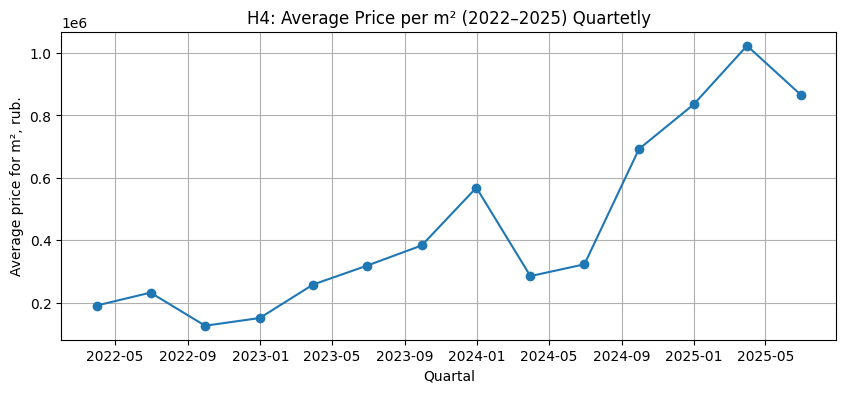


=== H4: Temporal Trend (OLS) ===
                            OLS Regression Results                            
Dep. Variable:      price_per_m2_sale   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     38.68
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           4.45e-05
Time:                        23:20:10   Log-Likelihood:                -185.59
No. Observations:                  14   AIC:                             375.2
Df Residuals:                      12   BIC:                             376.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.6

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [9]:
df_ts = df[['time', 'price_per_m2_sale']].dropna().set_index('time').sort_index()
quarterly_avg = df_ts['price_per_m2_sale'].resample('Q').mean().reset_index()

quarterly_avg['quarter_num'] = np.arange(len(quarterly_avg))

plt.figure(figsize=(10, 4))
plt.plot(
    quarterly_avg['time'],
    quarterly_avg['price_per_m2_sale'],
    marker='o'
)
plt.title('H4: Average Price per m² (2022–2025) Quartetly')
plt.xlabel('Quartal')
plt.ylabel('Average price for m², rub.')
plt.grid(True)
plt.show()

X_q = sm.add_constant(quarterly_avg['quarter_num'])
y_q = quarterly_avg['price_per_m2_sale']
h4_model = sm.OLS(y_q, X_q).fit()

print("\n=== H4: Temporal Trend (OLS) ===")
print(h4_model.summary())


In [8]:
df_h5 = df[
    df['price_per_m2_sale'].notna() &
    df['total_area_sale'].notna() &
    df['floor_sale'].notna() &
    df['coords_lat'].notna() &
    df['coords_lng'].notna() &
    df['property_type_sale'].notna()
].copy()

df_h5 = df_h5[df_h5['property_type_sale'].isin(valid_types)].copy()

df_h5['property_type_code'] = df_h5['property_type_sale'].astype('category').cat.codes

features_A = ['total_area_sale', 'floor_sale', 'km_do_metro', 'property_type_code']
features_B = features_A + ['coords_lat', 'coords_lng', 'year', 'month']

X_A = df_h5[features_A]
X_B = df_h5[features_B]
y = df_h5['price_per_m2_sale']

X_A_train, X_A_test, y_train, y_test = train_test_split(
    X_A, y, test_size=0.2, random_state=42
)
X_B_train, X_B_test, _, _ = train_test_split(
    X_B, y, test_size=0.2, random_state=42
)

model_A = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)
model_A.fit(X_A_train, y_train)

model_B = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)
model_B.fit(X_B_train, y_train)

y_pred_A = model_A.predict(X_A_test)
y_pred_B = model_B.predict(X_B_test)

mae_A = mean_absolute_error(y_test, y_pred_A)
rmse_A = np.sqrt(mean_squared_error(y_test, y_pred_A))

mae_B = mean_absolute_error(y_test, y_pred_B)
rmse_B = np.sqrt(mean_squared_error(y_test, y_pred_B))

print("\n=== H5: Feature Contribution to Prediction ===")
print(f"Model A (без гео/временных признаков): MAE = {mae_A:.2f}, RMSE = {rmse_A:.2f}")
print(f"Model B (с гео/временными признаками): MAE = {mae_B:.2f}, RMSE = {rmse_B:.2f}")

feature_importances = model_B.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': features_B,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance (Model B):")
print(feature_importance_df)


=== H5: Feature Contribution to Prediction ===
Model A (без гео/временных признаков): MAE = 115112.50, RMSE = 643619.41
Model B (с гео/временными признаками): MAE = 420664.99, RMSE = 10297522.80

Feature Importance (Model B):
              feature  importance
2         km_do_metro    0.955741
5          coords_lng    0.030953
1          floor_sale    0.008116
0     total_area_sale    0.002961
4          coords_lat    0.000964
7               month    0.000551
3  property_type_code    0.000508
6                year    0.000207
